In [42]:
import tensorflow as tf

In [43]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [44]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-12-27 03:28:53--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.002s  

2020-12-27 03:28:53 (38.4 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



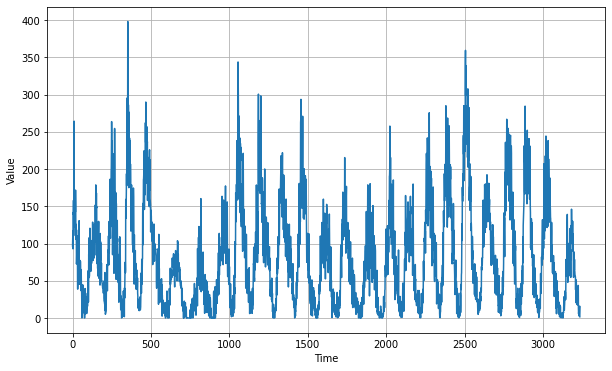

In [45]:
import csv
time_step = []
temps = []

with open('/content/Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[2]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

min = np.min(series)
max = np.max(series)
series -= min
series /= max

In [50]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [51]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [48]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [56]:

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

# train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
93/93 [==============================] - 3s 10ms/step - loss: 0.0339 - mae: 0.1989
Epoch 2/150
93/93 [==============================] - 1s 9ms/step - loss: 0.0338 - mae: 0.1986
Epoch 3/150
93/93 [==============================] - 1s 9ms/step - loss: 0.0333 - mae: 0.1958
Epoch 4/150
93/93 [==============================] - 1s 9ms/step - loss: 0.0314 - mae: 0.1890
Epoch 5/150
93/93 [==============================] - 1s 9ms/step - loss: 0.0309 - mae: 0.1862
Epoch 6/150
93/93 [==============================] - 1s 9ms/step - loss: 0.0302 - mae: 0.1827
Epoch 7/150
93/93 [==============================] - 1s 10ms/step - loss: 0.0302 - mae: 0.1822
Epoch 8/150
93/93 [==============================] - 1s 9ms/step - loss: 0.0288 - mae: 0.1766
Epoch 9/150
93/93 [==============================] - 1s 9ms/step - loss: 0.0283 - mae: 0.1752
Epoch 10/150
93/93 [==============================] - 1s 9ms/step - loss: 0.0291 - mae: 0.1769
Epoch 11/150
93/93 [==============================] - 1s 

In [57]:
model.save("mymodel.h5")